# Instructions
- From the __File__ menu, __Save a copy in Drive__. otherwise you will not be able to edit it

---
- From the __Runtime__ menu,  click on __Change runtime type__ . Here in __Hardware accelerator__ choose __GPU__ and __SAVE__

---
- To run a __Single Cell__ __ctrl + enter__
- To run  __all cells:ctrl + F9__
- To run  __all cells after:ctrl + F10__
- To run  __all cells before:ctrl + F8__
---

- run the __cell below__  (with the line __pip install -I --no-cache-dir pillow__). Go to __Runtime__ menu and __Restart runtime__
- After restarting, you can run all the cells

In [0]:
PLATFORM = 'colab'
if PLATFORM == 'colab':
#     !pip install -I --no-cache-dir pillow
    pass

In [0]:
if PLATFORM == 'colab':
    !git clone https://github.com/tumble-weed/suriya-self-supervised.git
    !mv suriya-self-supervised/*.py .
    !rm -rf suriya-self-supervised
    !wget -nc --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KliNy-Jx-_ZaK12pm8BA2qKAJOt0483_" -O part_labels.zip && rm -rf /tmp/cookies.txt
    !unzip -o part_labels.zip
    
    DATA_ROOT = './'
elif PLATFORM == 'cosmos':
    DATA_ROOT = './'

Cloning into 'suriya-self-supervised'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
File ‘part_labels.zip’ already there; not retrieving.
Archive:  part_labels.zip
  inflating: part_labels/data/gt/Michael_Doleac_0001.png  
  inflating: part_labels/data/gt/Heinrich_Wolfgang_0001.png  
  inflating: part_labels/data/gt/Mike_Babcock_0002.png  
  inflating: part_labels/data/gt/Steve_Nash_0002.png  
  inflating: part_labels/data/gt/Hugh_Grant_0009.png  
  inflating: part_labels/data/gt/Kathryn_Tucker_0001.png  
  inflating: part_labels/data/gt/Derek_Bond_0001.png  
  inflating: part_labels/data/gt/Laura_Bush_0032.png  
  inflating: part_labels/data/gt/Brendan_Stai_0001.png  
  inflating: part_labels/data/gt/Asa_Hutchinson_0002.png  
  inflating: part_labels/data/gt/Chung_Mong-hun_0002.png  
  inflating: part_la

In this notebook, we will see how useful are the self-supervised pre-training techniques. We pick face parsing task to evaluate the models. Note that this pre-training strategy is also applicable for other tasks such as object recognition, detection, segmentation, etc. This is because most tasks share a similar underlying network architecture.


We will be using <a href="http://vis-www.cs.umass.edu/lfw/part_labels/">Part Labels dataset</a> in this experiment. The task is to label each pixel in the image into one of three classes: Background (blue), Hair (red), and skin (green).
<img src="http://vis-www.cs.umass.edu/lfw/part_labels/images/img_funneled.jpg" width=100><img src="http://vis-www.cs.umass.edu/lfw/part_labels/images/img_ground_truth.png" width=100> <br/>
There are 13,233 images in total, out of which 2,927 have been labeled. There are 1,500 train, 500 val, and 927 test images. We will be using only 10% of the training set in our experiments. For self-supervised pre-training we will use 5,000 images.


We will measure three metrics: mIoU, pixel accuracy and frequency weighted pixel accuracy. These are the popular metrics use in semantic segmentation tasks.

In [0]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
# from torch.autograd import Variable
import torch.nn as nn

### import other stuffs
from enc_dec import encoder_decoder
from loss import *
from utils import *

import matplotlib.pyplot as plt

DATA_ROOT = './'

In [0]:
import numpy as np
import cv2
import torch
from torch.utils import data
from random import shuffle
import os.path
import collections



class SegmentationDataset(data.Dataset):
    
    def __init__(self, img_root, gt_root, image_list, split = 'train',
                     mirror = True, mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434]),   
                     transform=True):
        
        np.random.seed(7)
        ### paths
        self.img_root = img_root
        self.gt_root = gt_root

        self.split = split
        
        ### list of all images
        self.image_list = [line.rstrip('\n') for line in open(image_list)]
        
        
        ### augmentations
        self.mirror = mirror
           
        
        self._transform = transform
        self.mean_bgr=mean_bgr
        
        self.files = {}
        for f in self.image_list:
            if self.split not in self.files.keys():
                self.files[self.split] = []
            self.files[self.split].append({'img': img_root+f, 'lbl': gt_root+f})
        
    def __len__(self):
        return len(self.files[self.split])


    def __getitem__(self, index):
        
        imname = self.image_list[index]
        imname = imname.replace('.png','.jpg') 
        idt = imname[:-9]
        
#         idt = idt.replace('_',' ')
        image_file_name = self.img_root  + idt +'/'+imname 
        seg_gt_name = self.gt_root + self.image_list[index]
        
        ### read image
        image = None
        if os.path.isfile(image_file_name):
            image = cv2.imread(image_file_name)
        else:
            print('ERROR: couldn\'t find image -> ', image_file_name)
        
            
        ### read segmentation gt as greyscale image
        seg_gt = None
        if os.path.isfile(seg_gt_name):
            gt = cv2.imread(seg_gt_name)
            seg_gt = np.zeros((gt.shape[0], gt.shape[1]), dtype=np.uint8)
            ind1 = np.where(gt[:,:,1] == 255)
            seg_gt[ind1] = 1
            ind2 = np.where(gt[:,:,2] == 255)
            seg_gt[ind2] = 2
        else:
            print('ERROR: couldn\'t find segmentation gt ->', seg_gt_name)
        
        
        ### apply mirroring
        if self.mirror:
            flip = torch.LongTensor(1).random_(0, 2)[0]*2-1
            image = image[:, ::flip, :]
            seg_gt = seg_gt[:, ::flip]

            
        
        ### shuffle list after epoch
        if index == len(self.image_list):
#             shuffle(self.indexlist) # mistake, should be image_list
            shuffle(self.image_list)
            
        if self._transform:
            return self.transform(image, seg_gt)
            
    

    def transform(self, img, lbl):
        img = img.astype(np.float64)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img.copy()).float()
        lbl = torch.from_numpy(lbl.copy()).long()
        return img, lbl


In [0]:
### define dataset paths
# train_img_root = DATA_ROOT + 'part_labels/data/images/'
train_img_root = DATA_ROOT + 'part_labels/data/all/'
train_gt_root = DATA_ROOT + 'part_labels/data/gt/'
train_image_list = DATA_ROOT + 'part_labels/splits/train_10p.txt'

# val_img_root = DATA_ROOT + 'part_labels/data/images/'
val_img_root = DATA_ROOT + 'part_labels/data/all/'
val_gt_root = DATA_ROOT + 'part_labels/data/gt/'
val_image_list = DATA_ROOT + 'part_labels/splits/minival.txt'

test_img_root = DATA_ROOT + 'part_labels/data/all/'
test_gt_root = DATA_ROOT + 'part_labels/data/gt/'
test_image_list = DATA_ROOT + 'part_labels/splits/test.txt'

nClasses = 3
mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])

In [0]:
train_loader = torch.utils.data.DataLoader(SegmentationDataset(img_root = train_img_root, gt_root = train_gt_root,
                                                                  image_list = train_image_list, transform=True, mirror = True),
                                           batch_size=16, num_workers=2, shuffle = True, pin_memory=False)

val_loader = torch.utils.data.DataLoader(SegmentationDataset(img_root = val_img_root, gt_root = val_gt_root,
                                                                  image_list = val_image_list, transform=True, mirror = False),
                                           batch_size=16, num_workers=2, shuffle = False, pin_memory=False)

test_loader = torch.utils.data.DataLoader(SegmentationDataset(img_root = test_img_root, gt_root = test_gt_root,
                                                                  image_list = test_image_list, transform=True, mirror = False),
                                           batch_size=16, num_workers=2, shuffle = False, pin_memory=False)

<img src="https://docs.google.com/drawings/d/e/2PACX-1vT_ZXwfGNnjfS221bBh9HDxGM79aavoLARgwHep4hKvlql1si6qscZ9M4fhXKCWxuXNRy6tgBvj__GD/pub?w=2011&h=331" />

In [0]:
'''Experiment 1: train semantic segmentation network form scratch using 10% of training data'''
'''Initialize model with random weights (He initialization).'''
experiment = 'from_scratch'
net = encoder_decoder().cuda()

# 55.098452484703344 82.77928629989214 71.4377468041187


In [0]:
'''Experiment 2: Fine-tune semantic segmentation network using pre-trained encoder (context prediction) using 10% of training data'''
'''Load the pre-trained encoder'''

experiment = 'from_relative_tiles_pre_training'
net = torch.load(DATA_ROOT + 'checkpoint/self_supervised_pre_train_semantic_inpaintingckpt.t7')['net']

upsample = nn.Upsample(scale_factor=2, mode='bilinear')

'''Add the decoder to the model. Note that the decoder is initialized with random weights'''
net.decoder = nn.Sequential(upsample, nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64),
                            upsample, nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(32), 
                            upsample, nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=0, bias=False), nn.BatchNorm2d(16), 
                            upsample, nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=0, bias=True))

net.cuda()

# 62.867514016826135 86.01381488673138 76.27833472519274

EncoderDecoder(
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (e_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (e_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (e_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (e_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (e_bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e_conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (e_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (d_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [0]:
os.listdir('checkpoint')

['self_supervised_pre_train_semantic_inpaintingckpt.t7']

In [0]:
'''Experiment 3: Fine-tune semantic segmentation network using pre-trained encoder-decoder (context inpainting) using 10% of training data'''
'''Load the pre-trained encoder-decoder'''
net = torch.load(DATA_ROOT + 'checkpoint/self_supervised_pre_train_semantic_inpaintingckpt.t7')['net'].cuda()
experiment = 'from_semantic_inpainting_pre_training'
# 65.35361380810471 87.81917583603021 78.72283941521574

In [0]:
print('Net params count (M): ', param_counts(net)/(1000000.0))

Net params count (M):  0.121251


In [0]:
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy

In [0]:
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [60,80], gamma=0.1, last_epoch=-1)

for epoch in range(0, 100):
    '''
    train
    '''
    print('\nTrain epoch: %d' % epoch)
    net.train()
    hist = np.zeros((nClasses, nClasses))+1e-12
    train_loss = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
#         inputs = Variable(inputs)
        outputs = net(inputs)
        
        loss = cross_entropy2d(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correctLabel = labels.view(-1, labels.size()[1], labels.size()[2])

        hist += fast_hist(correctLabel.view(correctLabel.size(0),-1).cpu().numpy(),
                        predicted.view(predicted.size(0),-1).cpu().numpy(),
                        nClasses)
        
        
        miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(train_loader),hist,train_loss/(batch_idx+1),is_train=True)     
        

    miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(train_loader),hist,train_loss/(batch_idx+1),is_train=True)
    print('train: mIoU/Accuracy/Freqweighted_Accuracy', miou, p_acc, fwacc)

    '''
    validation
    '''

    print('\nVal epoch: %d' % epoch)

    net.eval()
    val_loss = 0
    hist = np.zeros((nClasses, nClasses))+1e-12
    for batch_idx, (inputs, labels) in enumerate(val_loader):
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

#         inputs = Variable(inputs)
        outputs = net(inputs)
        loss = cross_entropy2d(outputs, labels)

        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correctLabel = labels.view(-1, labels.size()[1], labels.size()[2])

        hist += fast_hist(correctLabel.view(correctLabel.size(0),-1).cpu().numpy(),
                        predicted.view(predicted.size(0),-1).cpu().numpy(),
                        nClasses)
        
        
        miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(val_loader),hist,val_loss/(batch_idx+1),is_train=False)
              
        

    miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(val_loader),hist,val_loss/(batch_idx+1),is_train=False)
    print('val: mIoU/Accuracy/Freqweighted_Accuracy', miou, p_acc, fwacc)

    # Save checkpoint.
    if p_acc > best_acc:
        print('Saving..')
        state = {'net': net}
        if not os.path.isdir(DATA_ROOT + 'checkpoint'):
            os.mkdir(DATA_ROOT + 'checkpoint')
        torch.save(state, DATA_ROOT + 'checkpoint/'+experiment+'ckpt.t7')
        best_acc = p_acc
    
    
    '''
    lr scheduler
    '''
    lr_scheduler.step()


Train epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


train: mIoU/Accuracy/Freqweighted_Accuracy 26.870506073228228 55.908416 46.430165536714014

Val epoch: 0
val: mIoU/Accuracy/Freqweighted_Accuracy 27.64333998359019 57.160512 48.49928950082904
Saving..

Train epoch: 1
train: mIoU/Accuracy/Freqweighted_Accuracy 29.040874791867715 62.31803733333333 50.69128464637062

Val epoch: 1
val: mIoU/Accuracy/Freqweighted_Accuracy 29.885378991862982 63.34816 50.84400334067729
Saving..

Train epoch: 2
train: mIoU/Accuracy/Freqweighted_Accuracy 31.081597949606426 68.26347200000001 51.58226118021476

Val epoch: 2
val: mIoU/Accuracy/Freqweighted_Accuracy 26.16228672864573 68.673088 48.202144953003945
Saving..

Train epoch: 3
train: mIoU/Accuracy/Freqweighted_Accuracy 31.42378714765886 69.767424 50.99392069586172

Val epoch: 3
val: mIoU/Accuracy/Freqweighted_Accuracy 38.94277872911065 74.305856 58.00855099867231
Saving..

Train epoch: 4
train: mIoU/Accuracy/Freqweighted_Accuracy 34.142563084918706 71.83272533333334 53.331838710367386

Val epoch: 4
val: m

In [0]:
net = torch.load(DATA_ROOT + 'checkpoint/'+experiment+'ckpt.t7')['net'].cuda().eval()

In [0]:
def apply_color_map(x):
    img = np.zeros((x.shape[0], x.shape[1], 3), dtype = np.uint8)
    indices = np.where(x==0)
    
    img[indices[0], indices[1] ,2] = 255
    
    indices = np.where(x==1)
    img[indices[0], indices[1] ,1] = 255
    
    indices = np.where(x==2)
    img[indices[0], indices[1] ,0] = 255
    
    return img

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


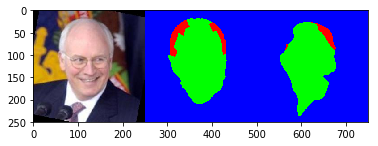

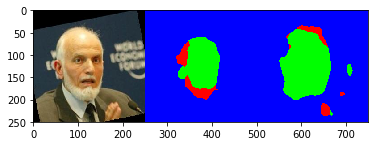

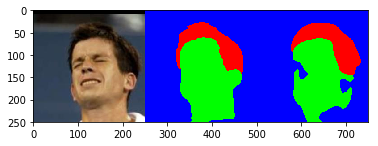

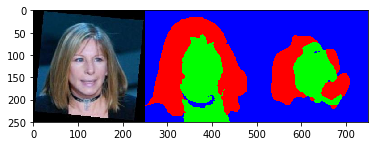

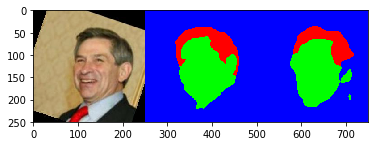

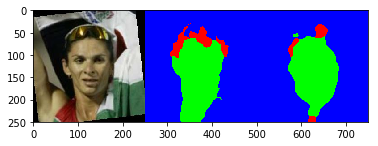

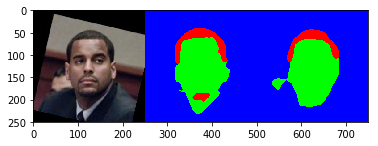

test: mIoU/Accuracy/Freqweighted_Accuracy 68.5137442087101 87.952192 79.11727043980355


In [0]:
net.eval()
test_loss = 0
hist = np.zeros((nClasses, nClasses))+1e-12
for batch_idx, (inputs, labels) in enumerate(test_loader):
    if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
#     inputs = Variable(inputs)
    outputs = net(inputs)
    loss = cross_entropy2d(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)

    i = (inputs[0].data.cpu().numpy().transpose(1,2,0) + mean_bgr).astype(np.uint8)[:,:,::-1]
    g = apply_color_map(labels[0].cpu().numpy())
    o = apply_color_map(predicted[0].cpu().numpy())
    vis = np.concatenate((i,g,o), axis = 1)
    plt.imshow(vis)
    plt.show()

    correctLabel = labels.view(-1, labels.size()[1], labels.size()[2])

    hist += fast_hist(correctLabel.view(correctLabel.size(0),-1).cpu().numpy(),
                    predicted.view(predicted.size(0),-1).cpu().numpy(),
                    nClasses)


    miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(test_loader),hist,test_loss/(batch_idx+1),is_train=False)



miou, p_acc, fwacc = performMetrics(epoch,batch_idx,len(test_loader),hist,test_loss/(batch_idx+1),is_train=False)
print('test: mIoU/Accuracy/Freqweighted_Accuracy', miou, p_acc, fwacc)